Erin Orbits  
Project Due Oct 19, 2017 by 4:59 p.m.

In [209]:
# This code displays all results created within a jupyter notebook cell.
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# This code displays Matplotlib objects inline.
from IPython import get_ipython
get_ipython().run_line_magic('matplotlib', 'inline')

## Step 1: Data acquisition

#### Pagecount Get Requests
https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/desktop-site/monthly/2008010100/2017100100  

https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/en.wikipedia.org/desktop-site/monthly/2008010100/2017100100
  
#### Pageview Get Requests
http://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia/mobile-app/user/monthly/2015080100/2017100100

https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia/mobile-web/user/monthly/2015080100/2017100100

http://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/en.wikipedia/desktop/user/monthly/2015080100/2017100100

In [4]:
import csv
import json
import requests

# Endpoints to be modified with parameters during API calls.
endpoint_pageview = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
endpoint_pagecount = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access}/{granularity}/{start}/{end}'

# Do we need this?
# headers={'User-Agent' : 'https://github.com/orbitse', 'From' : 'orbite@uw.edu'}

params_pageviews = {"project" : "en.wikipedia.org",
                    "access" : "desktop", # ["desktop", "mobile-app", "mobile-web"]
                    "agent" : "user",
                    "granularity" : "monthly",
                    "start" : "2015080100",
                    "end" : '2017101000'#use first day of following month to ensure a full month of data is collected
                    }

params_pagecounts = {"project" : "en.wikipedia.org",
                     "access" : "desktop-site", # ["desktop-site","mobile-site"]
                     "granularity" : "monthly",
                     "start" : "2008010100",
                     "end" : "2017100100"#use first day of following month to ensure a full month of data is collected
                    }

def api_call(api_type="pageview", parameters=params_pageviews, file_name="api_file.json"):
    """
    This function calls the API and gets a JSON response in a format like this:
        {"items":[{"project":"en.wikipedia","access-site":"desktop-site",
                   "granularity":"monthly","timestamp":"2008010100","count":4930902570},...
    Then saves the JSON file with the corresponding name and returns the JSON object.
    """
    if api_type == "pageview":
        endpoint_pageview = 'https://wikimedia.org/api/rest_v1/metrics/pageviews/aggregate/{project}/{access}/{agent}/{granularity}/{start}/{end}'
        api_call = requests.get(endpoint_pageview.format(**parameters))
    elif api_type == "pagecount":
        endpoint_pagecount = 'https://wikimedia.org/api/rest_v1/metrics/legacy/pagecounts/aggregate/{project}/{access}/{granularity}/{start}/{end}'
        api_call = requests.get(endpoint_pagecount.format(**parameters))
    else:
        print("Please try to call api_call() again.")  
    response = api_call.json()   
    # save JSON file
    with open(file_name, "w") as file:
        json.dump(response, file)
    print("Saved File:", str(file_name))
    return(response)

json_file_names = ["pagecounts_desktop-site_200801-201607.json",
                   "pagecounts_mobile-site_200801-201607.json",
                   "pageviews_desktop_201508-201709.json",
                   "pageviews_mobile_201508-201709.json",
                   "pageviews_mobile-web_201508-201709.json"]

pageview_access = ["desktop", "mobile-app", "mobile-web"]
for item in pageview_access:
    params_pageviews["access"] = item
    api_call(api_type="pageview", parameters=params_pageviews,
             file_name="pageviews_"+str(item)+"_201508-201709.json")

pagecount_access = ["desktop-site","mobile-site"]
for item in pagecount_access:
    params_pagecounts["access"] = item
    api_call(api_type="pagecount", parameters=params_pagecounts,
             file_name="pagecounts_"+str(item)+"_200801-201607.json")


## Step 2: Data processing
You will need to perform a series of processing steps on these data files in order to prepare them for analysis. These steps must be followed exactly in order to prepare the data for analysis. At the end of this step, you will have a single CSV-formatted data file that can be used in your analysis (step 3) with no significant additional processing.  

For data collected from the Pageviews API, combine the monthly values for mobile-app and mobile-web to create a total mobile traffic count for each month.  

For all data, separate the value of timestamp into four-digit year (YYYY) and two-digit month (MM) and discard values for day and hour (DDHH).  

For all months with 0 pageviews for a given access method (_e.g._ desktop-site, mobile-app), that value for that (column, month) should be listed as 0. So for example all values of pagecount_mobile_views for months before October 2014 should be 0, because mobile traffic data is not available before that month.

The final data file should be named:
`en-wikipedia_traffic_200801-201709.csv`

In [160]:
import csv
import json
import pandas as pd

OUTPUT_FILE = "en-wikipedia_traffic_200801-201709.csv"

JSON_FILES = ["pagecounts_desktop-site_200801-201607.json",
              "pagecounts_mobile-site_200801-201607.json",
              "pageviews_desktop_201508-201709.json",
              "pageviews_mobile-app_201508-201709.json",
              "pageviews_mobile-web_201508-201709.json"]
  
DICT_DF = {0 : pagecounts_desktop_df,
           1 : pagecounts_mobile_df,
           2 : pageviews_desktop_df,
           3 : pageviews_mobileapp_df,
           4 : pageviews_mobileweb_df}

count = 0 

for jfile in JSON_FILES:
    
    with open(jfile, encoding="utf-8") as data_file:
        
        dict_data = json.load(data_file) # dictionary object
        extracted_items = dict_data["items"] # technically a list object
        
        # Create a DataFrame with "keys" as column names.
        DICT_DF[count] = pd.DataFrame.from_dict(extracted_items)
        
        # Create columns for year and month in DataFrame.
        DICT_DF[count]["year"] = DICT_DF[count]["timestamp"].str[0:4]
        DICT_DF[count]["month"] = DICT_DF[count]["timestamp"].str[4:6]
        
        # Standardize "access" and "access-site" columns to "access."
        if "access-site" in DICT_DF[count].columns:
            DICT_DF[count].rename(columns={"access-site" : "access"}, inplace=True)
        
        # Rename count or views column with specific name.
        if DICT_DF[count].get_value(index=1, col="access") == "desktop-site":
            DICT_DF[count].rename(index=str,
                                  columns={"count" : "pagecount_desktop_views",
                                           "views" : "pagecount_desktop_views"},
                                  inplace=True)
        elif DICT_DF[count].get_value(index=1, col="access") == "mobile-site":
            DICT_DF[count].rename(index=str,
                                  columns={"count" : "pagecount_mobile_views",
                                           "views" : "pagecount_mobile_views"},
                                  inplace=True)
        elif DICT_DF[count].get_value(index=1, col="access") == "desktop":
            DICT_DF[count].rename(index=str,
                                  columns={"count" : "pageview_desktop_views",
                                           "views" : "pageview_desktop_views"},
                                  inplace=True)
        elif DICT_DF[count].get_value(index=1, col="access") == "mobile-app":        
            DICT_DF[count].rename(index=str,
                                  columns={"count" : "pageview_mobile_views",
                                           "views" : "pageview_mobile_views"},
                                  inplace=True)
        elif DICT_DF[count].get_value(index=1, col="access") == "mobile-web":
            DICT_DF[count].rename(index=str,
                                  columns={"count" : "pageview_mobile_views",
                                           "views" : "pageview_mobile_views"},
                                  inplace=True)

        # If DataFrame includes an "agent" column, then drop these columns.
        if "agent" in DICT_DF[count].columns:
            # The axis number is 0 for rows and 1 for columns.
            # To delete DataFrame columns w/o reassigning, use inplace=True. 
            DICT_DF[count].drop(["access", "granularity", "agent", "project", "timestamp"],
                                axis=1, inplace=True)
        # If DataFrame doesn't include an "agent" column, then drop these columns.
        else:
            DICT_DF[count].drop(["access", "granularity", "project", "timestamp"],
                                axis=1, inplace=True)
        
        # Increment the counter for initial DataFrame names.    
        count = count + 1

# Merge the pagecount DataFrames, change NA values to 0, and
# add "pagecount_all_views" column.
df_pagecount = DICT_DF[0].merge(DICT_DF[1], how='outer', on=["year", "month"])
df_pagecount = df_pagecount.fillna(0)
df_pagecount["pagecount_all_views"] = df_pagecount["pagecount_desktop_views"] + df_pagecount["pagecount_mobile_views"]

# Merge the pageview DataFrames, change NA values to 0, and
# add "pageview_all_views" column.
df_mobile = DICT_DF[3].merge(DICT_DF[4], how='outer', on=["year", "month"])
df_mobile["pageview_mobile_views"] = df_mobile["pageview_mobile_views_x"] + df_mobile["pageview_mobile_views_y"]  
df_mobile.drop(["pageview_mobile_views_x", "pageview_mobile_views_y"],
               axis=1, inplace=True)
df_pageview = df_mobile.merge(DICT_DF[2], how='outer', on=["year", "month"])
df_pageview = df_pageview.fillna(0)
df_pageview["pageview_all_views"] = df_pageview["pageview_mobile_views"] + df_pageview["pageview_desktop_views"]

# Merge the pagecount and pageview DataFrames, and keep NA values as 0.
df_final = df_pagecount.merge(df_pageview, how='outer', on=["year", "month"])
df_final = df.fillna(0)

# Reorder the columns in the final DataFrame.
df_final = df_final[["year", "month", "pagecount_all_views",
                     "pagecount_desktop_views", "pagecount_mobile_views",
                     "pageview_all_views", "pageview_desktop_views",
                     "pageview_mobile_views"]]
df_final

# Remove original index and reset index as a multi-column index.
df_yr_mo_index = df_final.set_index("year", "month")

# Write final DataFrame to CSV file.
df_yr_mo_index.to_csv(OUTPUT_FILE, sep=",", encoding='utf-8')

,year,month,pagecount_all_views,pagecount_desktop_views,pagecount_mobile_views,pageview_all_views,pageview_desktop_views,pageview_mobile_views
0,2008,01,4.930903e+09,4.930903e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
1,2008,02,4.818394e+09,4.818394e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
2,2008,03,4.955406e+09,4.955406e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
3,2008,04,5.159162e+09,5.159162e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
4,2008,05,5.584691e+09,5.584691e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
5,2008,06,5.712104e+09,5.712104e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
6,2008,07,5.306303e+09,5.306303e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
7,2008,08,5.140156e+09,5.140156e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
8,2008,09,5.479534e+09,5.479534e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
9,2008,10,5.679441e+09,5.679441e+09,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00


## Step 3: Analysis

A sample visualization of Engligh Wikipedia traffic data as a time series graph tracking three traffic metrics: mobile traffic, desktop traffic, and all traffic (mobile + desktop).  

__Visualization Tools__  
To generate this visualization in the cell below, the following python libraries were used: [matplotlib](https://matplotlib.org), [seaborn](http://seaborn.pydata.org), and [pandas](http://pandas.pydata.org).  

__Data__  
While we could have read data from the CSV file, we used data from the combined DataFrame for the y values since `df_final` was already created in an earlier cell. For the x-axis values, we could have pulled the year and month from the CSV file or `df_final` but it was easiest to generate a date range with pandas, see the `dates` variable.

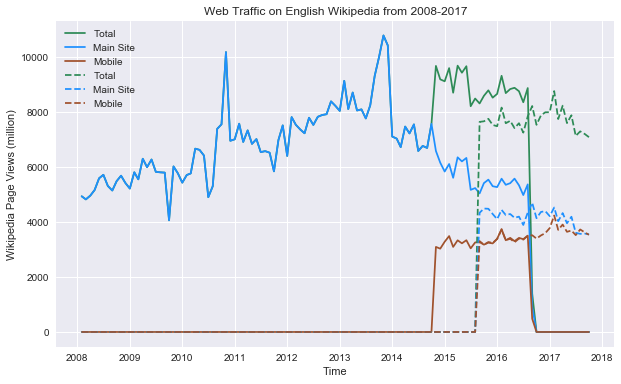

In [210]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn

# Generate values for x-axis.
dates = pd.date_range('2008-01', '2017-10', freq='M')

# Values to be plotted.
x = dates
y1 = df_final["pagecount_all_views"]/1000000
y2 = df_final["pagecount_desktop_views"]/1000000
y3 = df_final["pagecount_mobile_views"]/1000000
y4 = df_final["pageview_all_views"]/1000000
y5 = df_final["pageview_desktop_views"]/1000000
y6 = df_final["pageview_mobile_views"]/1000000

# Create a new figure with appropriate dimensions.
fig = plt.figure(figsize=(10, 6))

# Show grid
plt.grid(True)

plt.plot(x, y1, label = "Total", color = "seagreen")
plt.plot(x, y2, label = "Main Site", color = "dodgerblue")
plt.plot(x, y3, label = "Mobile", color = "sienna")
plt.plot(x, y4, "--", label = "Total", color = "seagreen")
plt.plot(x, y5, "--", label = "Main Site", color = "dodgerblue")
plt.plot(x, y6, "--", label = "Mobile", color = "sienna")

plt.legend()
plt.xlabel("Time")
plt.ylabel("Wikipedia Page Views (million)")
plt.title("Web Traffic on English Wikipedia from 2008-2017")

# Display plot
plt.show()

# Save plot to file
fig.savefig("WikipediaDataPlot.png")